In [1]:
%load_ext autoreload
%autoreload 2

------------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [4]:
import Util
from Util import long_header
from Util import to_log2_tpm

------

# Create Boxplots: **Transcription Efficiency** (TE)

This means we analyze the **ratios** between:
- Pol II RIP **(Nascent RNA)**
- Pol II ChIP **(Steady State RNA)**

previously computed and defined as **transcription efficiency**: `Pol II RIP / Pol II ChIP`


This Notebook is used to generate the following **Box Plots**:
- **Figure1**: *Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.*
    - WT - <del>**Figure1-C_stranded**</del>  <font color='red'> **Figure1-D_stranded** </font>
- **Figure2**: *Contribution of distinct pathways to heterochromatic silencing*
    - WT & clr4Δ - <del>**Figure2-B_stranded**</del>  <font color='red'> **Figure2-C_stranded** </font>
- **Figure3**: *RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants*
    - Mutant group 1 - **Figure3-C_stranded**
    - Mutant group 2 - **Figure3-D_stranded**

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [6]:
from viz_strands import prepare_4cat_data, multi_4cat_box_plot, my_multi_4cat_box_plot ## 4-category

-------------

### Data: **transcription_efficiency.csv**

In [7]:
#ratios_dir

- Import **Transcription Efficiency** (TE) matrix: `transcription_efficiency.csv`

In [8]:
#te_file=os.path.join(in_dir, 'transcription_efficiency.csv')
te_file=os.path.join(ratios_dir, 'transcription_efficiency.csv')
te_file

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/transcription_efficiency.csv'

In [9]:
df = pd.read_csv(te_file, sep='\t')
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.358903,0.049082,0.170271,0.062029,0.083316,0.055166,0.073347,0.231235,0.053812,0.030326,0.730143,0.100357,0.144801,0.045835
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.159937,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,0.078542,0.189788,0.393205,0.082533,0.109532,0.132110,0.193087,0.069192,0.060826,0.032955,0.246863,0.052037,0.139404,0.546394
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,0.354282,0.801533,0.201412,0.110041,0.257788,0.104558,0.045656,0.461440,0.114019,0.128023,0.478776,0.132112,0.411515,0.015965
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(5159, 20)

- Get **sample columns** for filtering `NA`s properly:

In [11]:
init_sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]

In [12]:
# Check if TE ratio is not well defined for any mutants. All NaNs
df = df.dropna(axis=1, how='all')

In [13]:
# get sample_cols after filtering
sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]
len(sample_cols)
#sample_cols

14

In [14]:
print('Ignoring samples: {} TE ratio is not well defined!'.format(set(init_sample_cols).difference(sample_cols)))

Ignoring samples: set() TE ratio is not well defined!


In [15]:
#df[df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id') | (xx == 'category')]]

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from **division by zero**: drop `NaN's` </font>

In [16]:
# (NOT USED)
#df = df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#df = df.fillna({kk:0 for kk in sample_cols})

# drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
# => why not fillna(0) like before, in `GXP_BoxPlots.ipynb`?
df = df.dropna(subset = sample_cols) 
#df = df.dropna(0)

In [17]:
df.shape

(5025, 20)

In [18]:
#df[df[sample_cols].isnull().any(1)]

In [19]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not df[sample_cols].isnull().values.any()

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [20]:
# log transformed `ratios` will be used to visualize boxplots
# => compute log(x), there should be no issues zeros due to ratio defined as (1 + x) / (1 + y)
#df = to_log2_tpm(df, gene_id_col='gene_id')  # default shift=1
df = to_log2_tpm(df, gene_id_col='gene_id', shift=0)  # parastou used this, default shift=1

# Keep only Heterochromatic genes and  protein coding genes (need to change for gff_v2)
#df = df[(df['category'] == 'repeat') | (df['type'] == 'gene')]
df = df[(df['bio_type'] == 'mRNA') | (df['category'] == 'repeat')]
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,-1.478335,-4.348664,-2.554098,-4.010913,-3.585269,-4.180067,-3.769120,-2.112569,-4.215922,-5.043318,-0.453749,-3.316788,-2.787854,-4.447411
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,-3.670392,-2.397536,-1.346648,-3.598893,-3.190576,-2.920192,-2.372674,-3.853250,-4.039161,-4.923359,-2.018215,-4.264306,-2.842657,-0.871986
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,-1.497030,-0.319165,-2.311777,-3.183886,-1.955741,-3.257628,-4.453052,-1.115786,-3.132649,-2.965528,-1.062578,-2.920169,-1.280982,-5.968975
5,FP565355_region_18009..20128,NaN,2120,region,repeat,region,-2.774182,-4.243496,-3.622644,-4.941660,-4.126211,-5.448097,-4.106715,-2.206363,-4.608982,-6.023367,-2.102850,-3.433345,-2.792723,-7.405028
7,FP565355_region_3260..3394,NaN,135,region,repeat,region,-3.670392,-2.397536,-1.346648,-3.598893,-3.190576,-2.920192,-2.372674,-3.853250,-4.039161,-4.923359,-2.018215,-4.264306,-2.842657,-0.871986


In [21]:
df.shape

(5025, 20)

In [22]:
#df[df['gene_id'].isin(non_degraded)]

In [23]:
assert not df[sample_cols].isnull().values.any()

----

### WT -  <del>**Figure1-C_stranded**</del>  <font color='red'> **Figure1-D_stranded** </font>

- **Figure 1**. Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.
    - **(C)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) in wild type cells for indicated genes. Average of at least two independent samples is shown. 

In [24]:
fig_dir = os.path.join(plots_dir, 'Figure1')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure1/Figure1-D_stranded.png


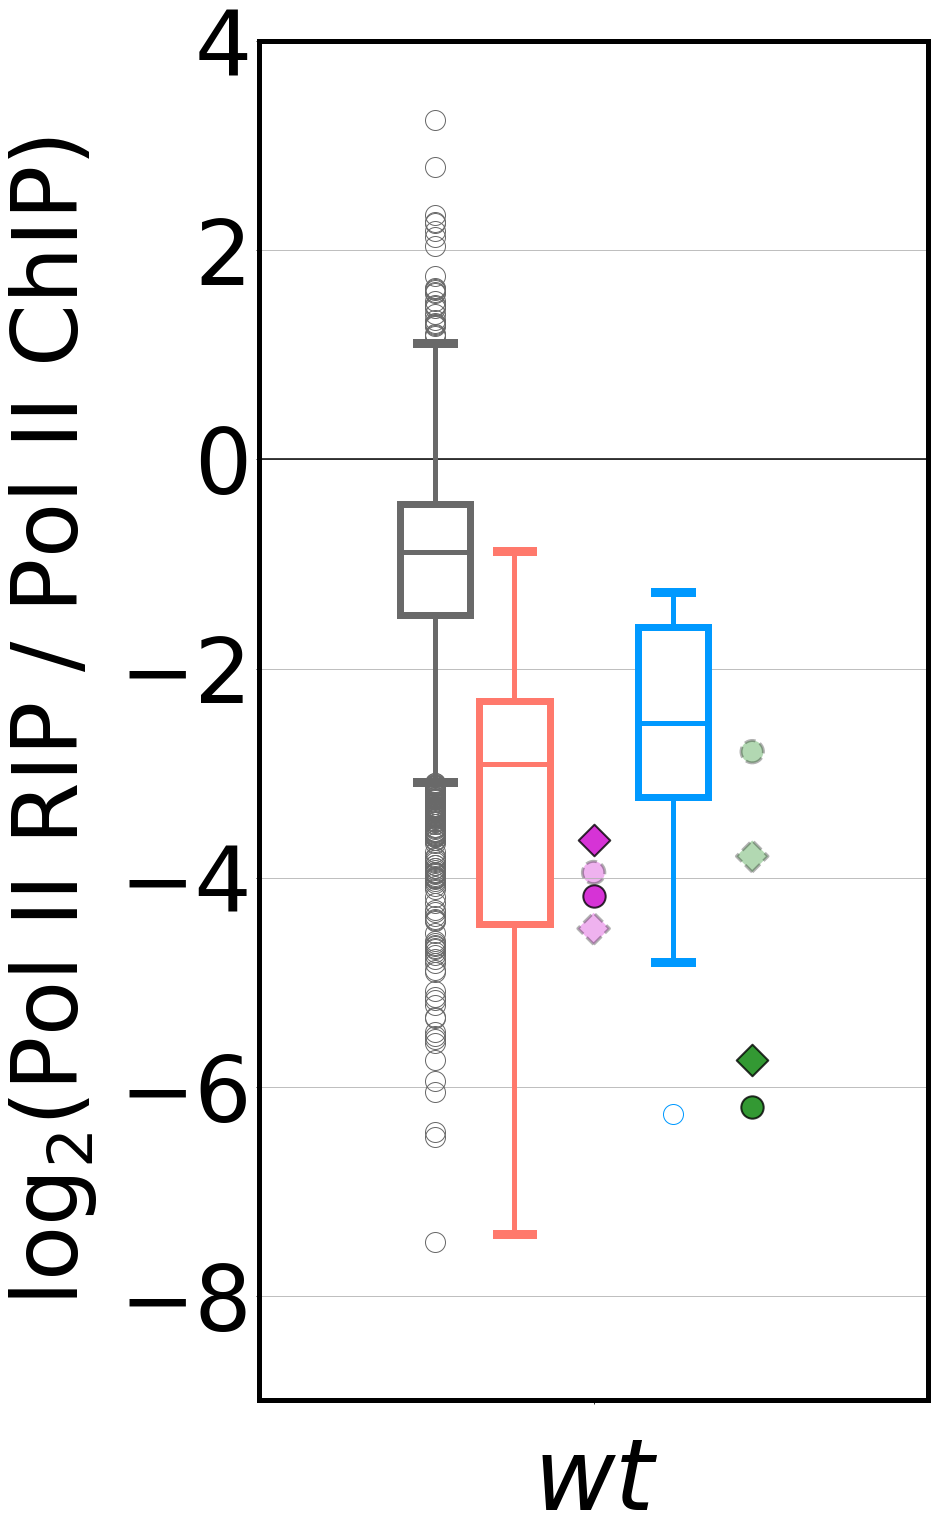

In [25]:
# data and labels
samples = ['WT']
x_labels = ['wt']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure1-C_stranded.png')
#out_path = os.path.join(fig_dir, 'Figure1-C_stranded.png')
out_path = os.path.join(fig_dir, 'Figure1-D_stranded.png')

print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels, 
                    out_path,
                    figsize=(12, 25),
                    dist=1, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$',
                    y_lim=(-9, 4), 
                    widths=.8,
                    hlines=[(0,'black')], 
                    xlable_size=100, ylable_size=90, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

---

### WT & clr4Δ - <del>**Figure2-B_stranded**</del>  <font color='red'> **Figure2-C_stranded** </font>

- **Figure 2**: Contribution of distinct pathways to heterochromatic silencing 
(A) Box plot showing RNA Pol II occupancy (Pol II ChIP-seq) in clr4Δ cells relative to wild type cells for indicated genes. 
    - **(B)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) in wild type and clr4Δ cells (absence of heterochromatin). Average of at least two independent samples is shown for all figures. 

In [26]:
fig_dir = os.path.join(plots_dir, 'Figure2')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure2/Figure2-C_stranded.png


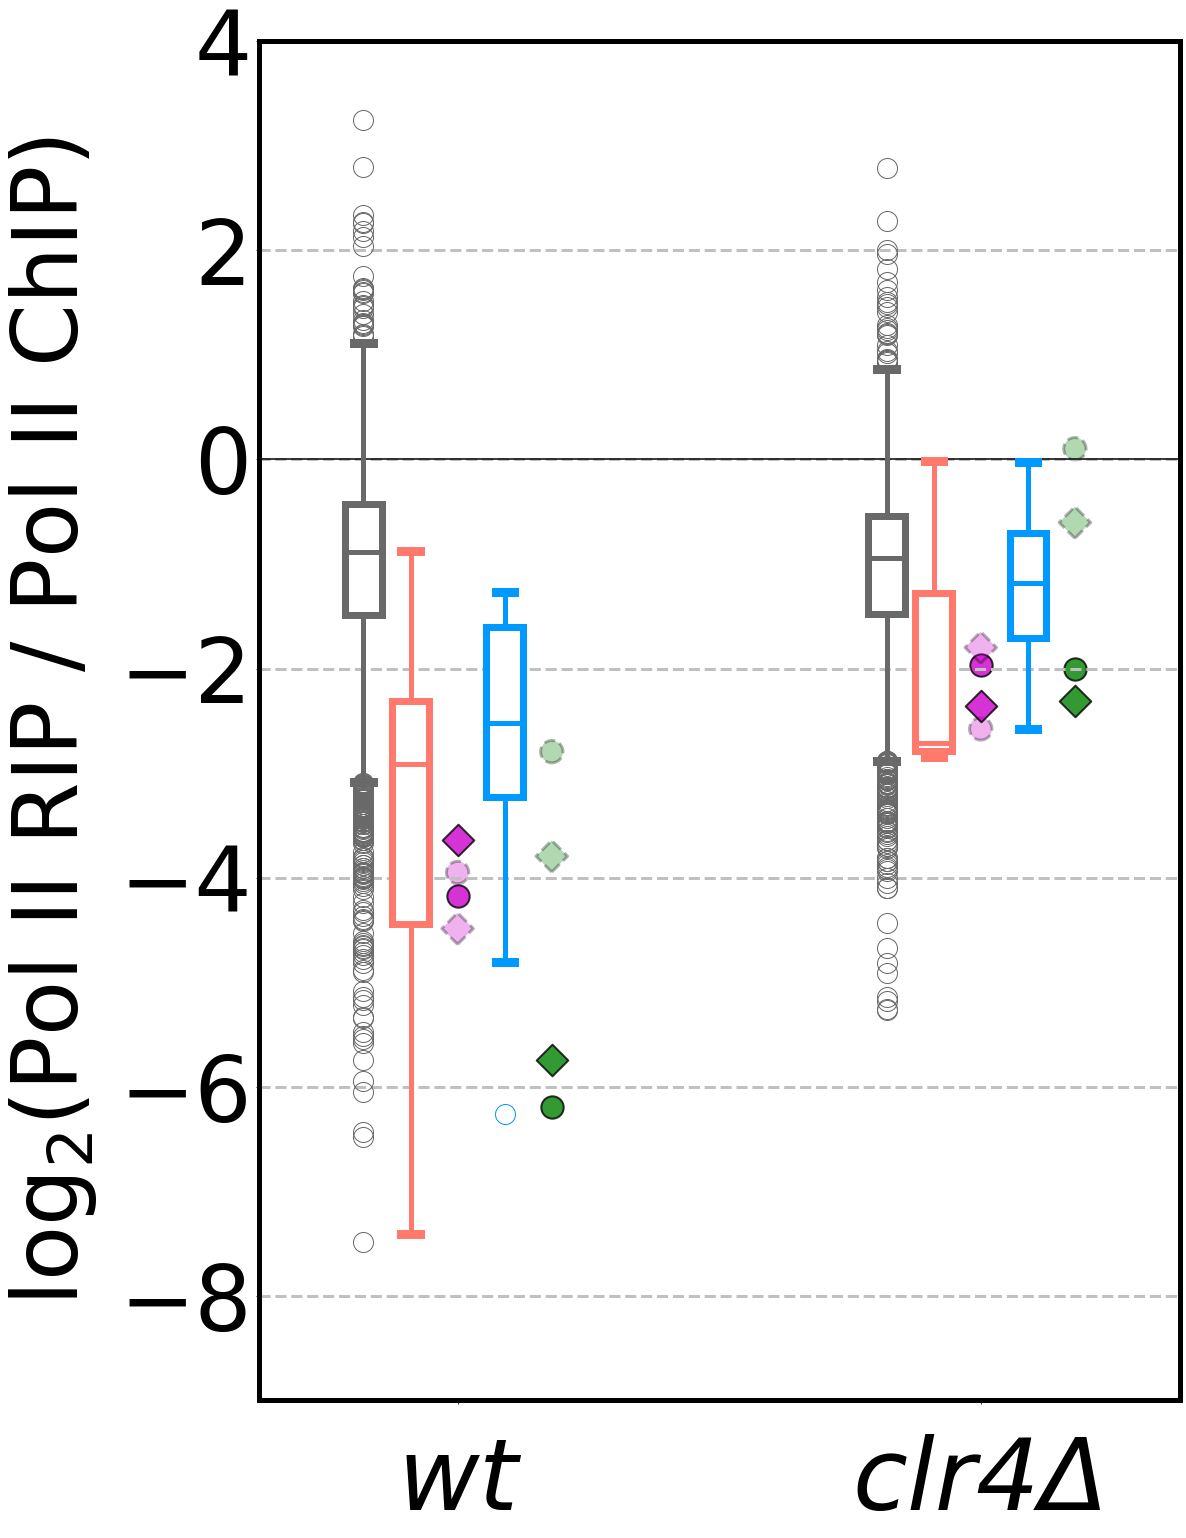

In [27]:
# data and labels
samples = ['WT', '80']
x_labels = ['wt', 'clr4Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure2-B_stranded.png')
#out_path = os.path.join(fig_dir, 'Figure2-B_stranded.png')
out_path = os.path.join(fig_dir, 'Figure2-C_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(16.5, 25),
                    dist=5, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$', 
                    y_lim=(-9, 4),
                    widths=.7,
                    hlines=[(0,'black')],
                    xlable_size=100, ylable_size=90, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

---

## Mutant group 1 - **Figure3-C_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(C+D)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) over indicated genes in wild type and mutant cells.

In [28]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-C_stranded.png


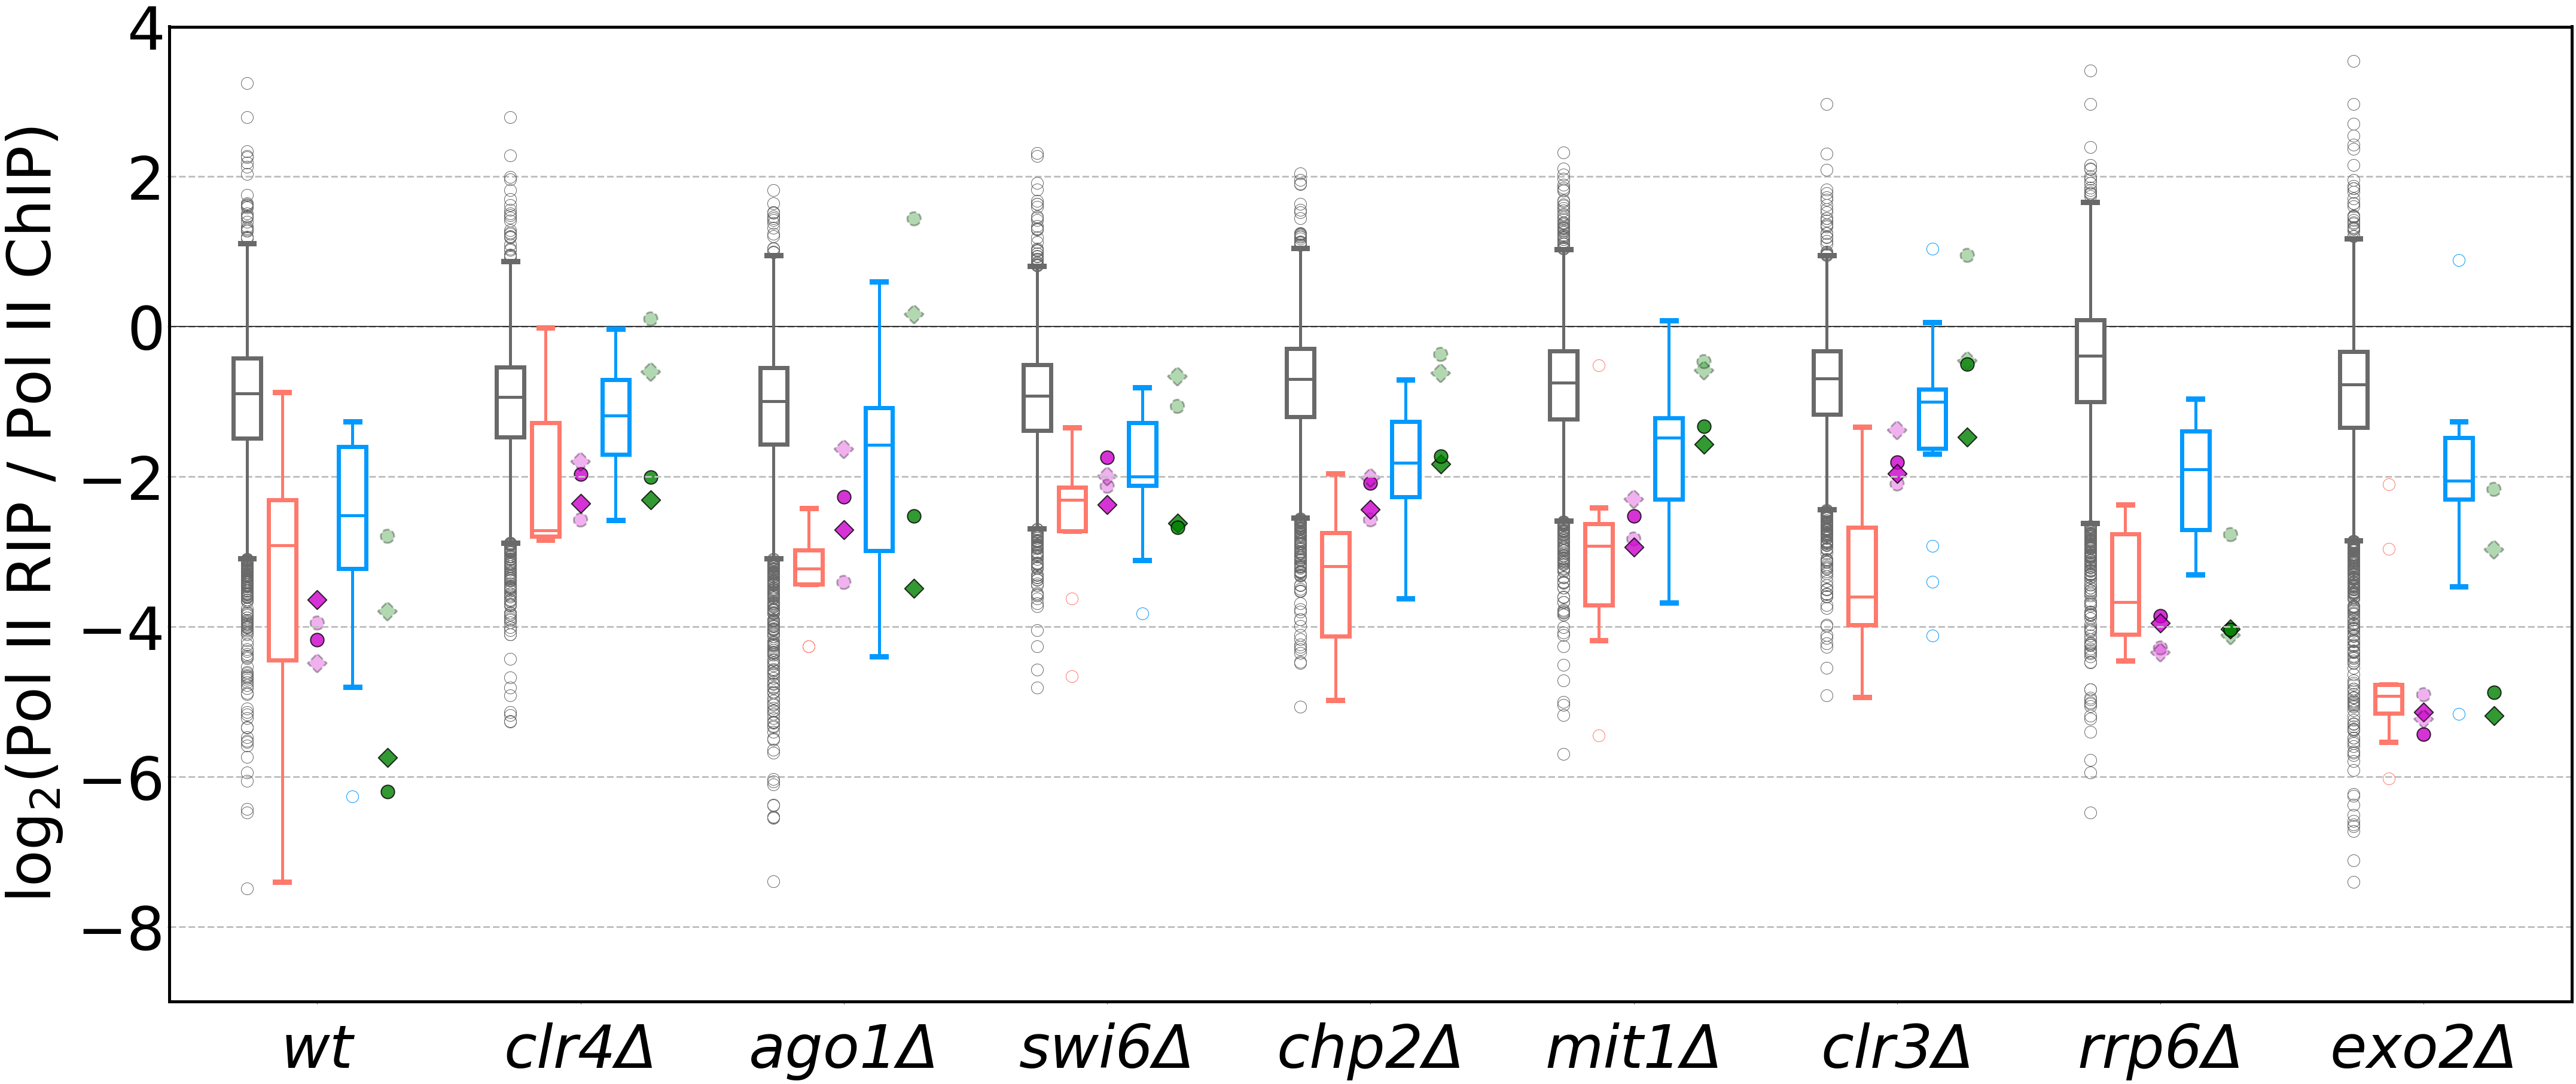

In [29]:
# data and labels
# samples = ['WT', '80', '638', '301', '324', '491', '302']
# x_labels = ['wt', 'clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ']

# data and labels - new version
samples = ['WT', '80', '638', '301', '324', '491', '302', '504', '530']
x_labels = ['wt', 'clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ', 'rrp6Δ', 'exo2Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure3-C_stranded.png')
out_path = os.path.join(fig_dir, 'Figure3-C_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(56, 30),
                    dist=6, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$', 
                    y_lim=(-9, 4), 
                    hlines=[(0,'black')],
                    #widths=.8,
                    widths=.7,
                    xlable_size=100, ylable_size=100, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

------

## Mutant group 2 - **Figure3-D_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(C+D)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) over indicated genes in wild type and mutant cells.

In [30]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-D_stranded.png


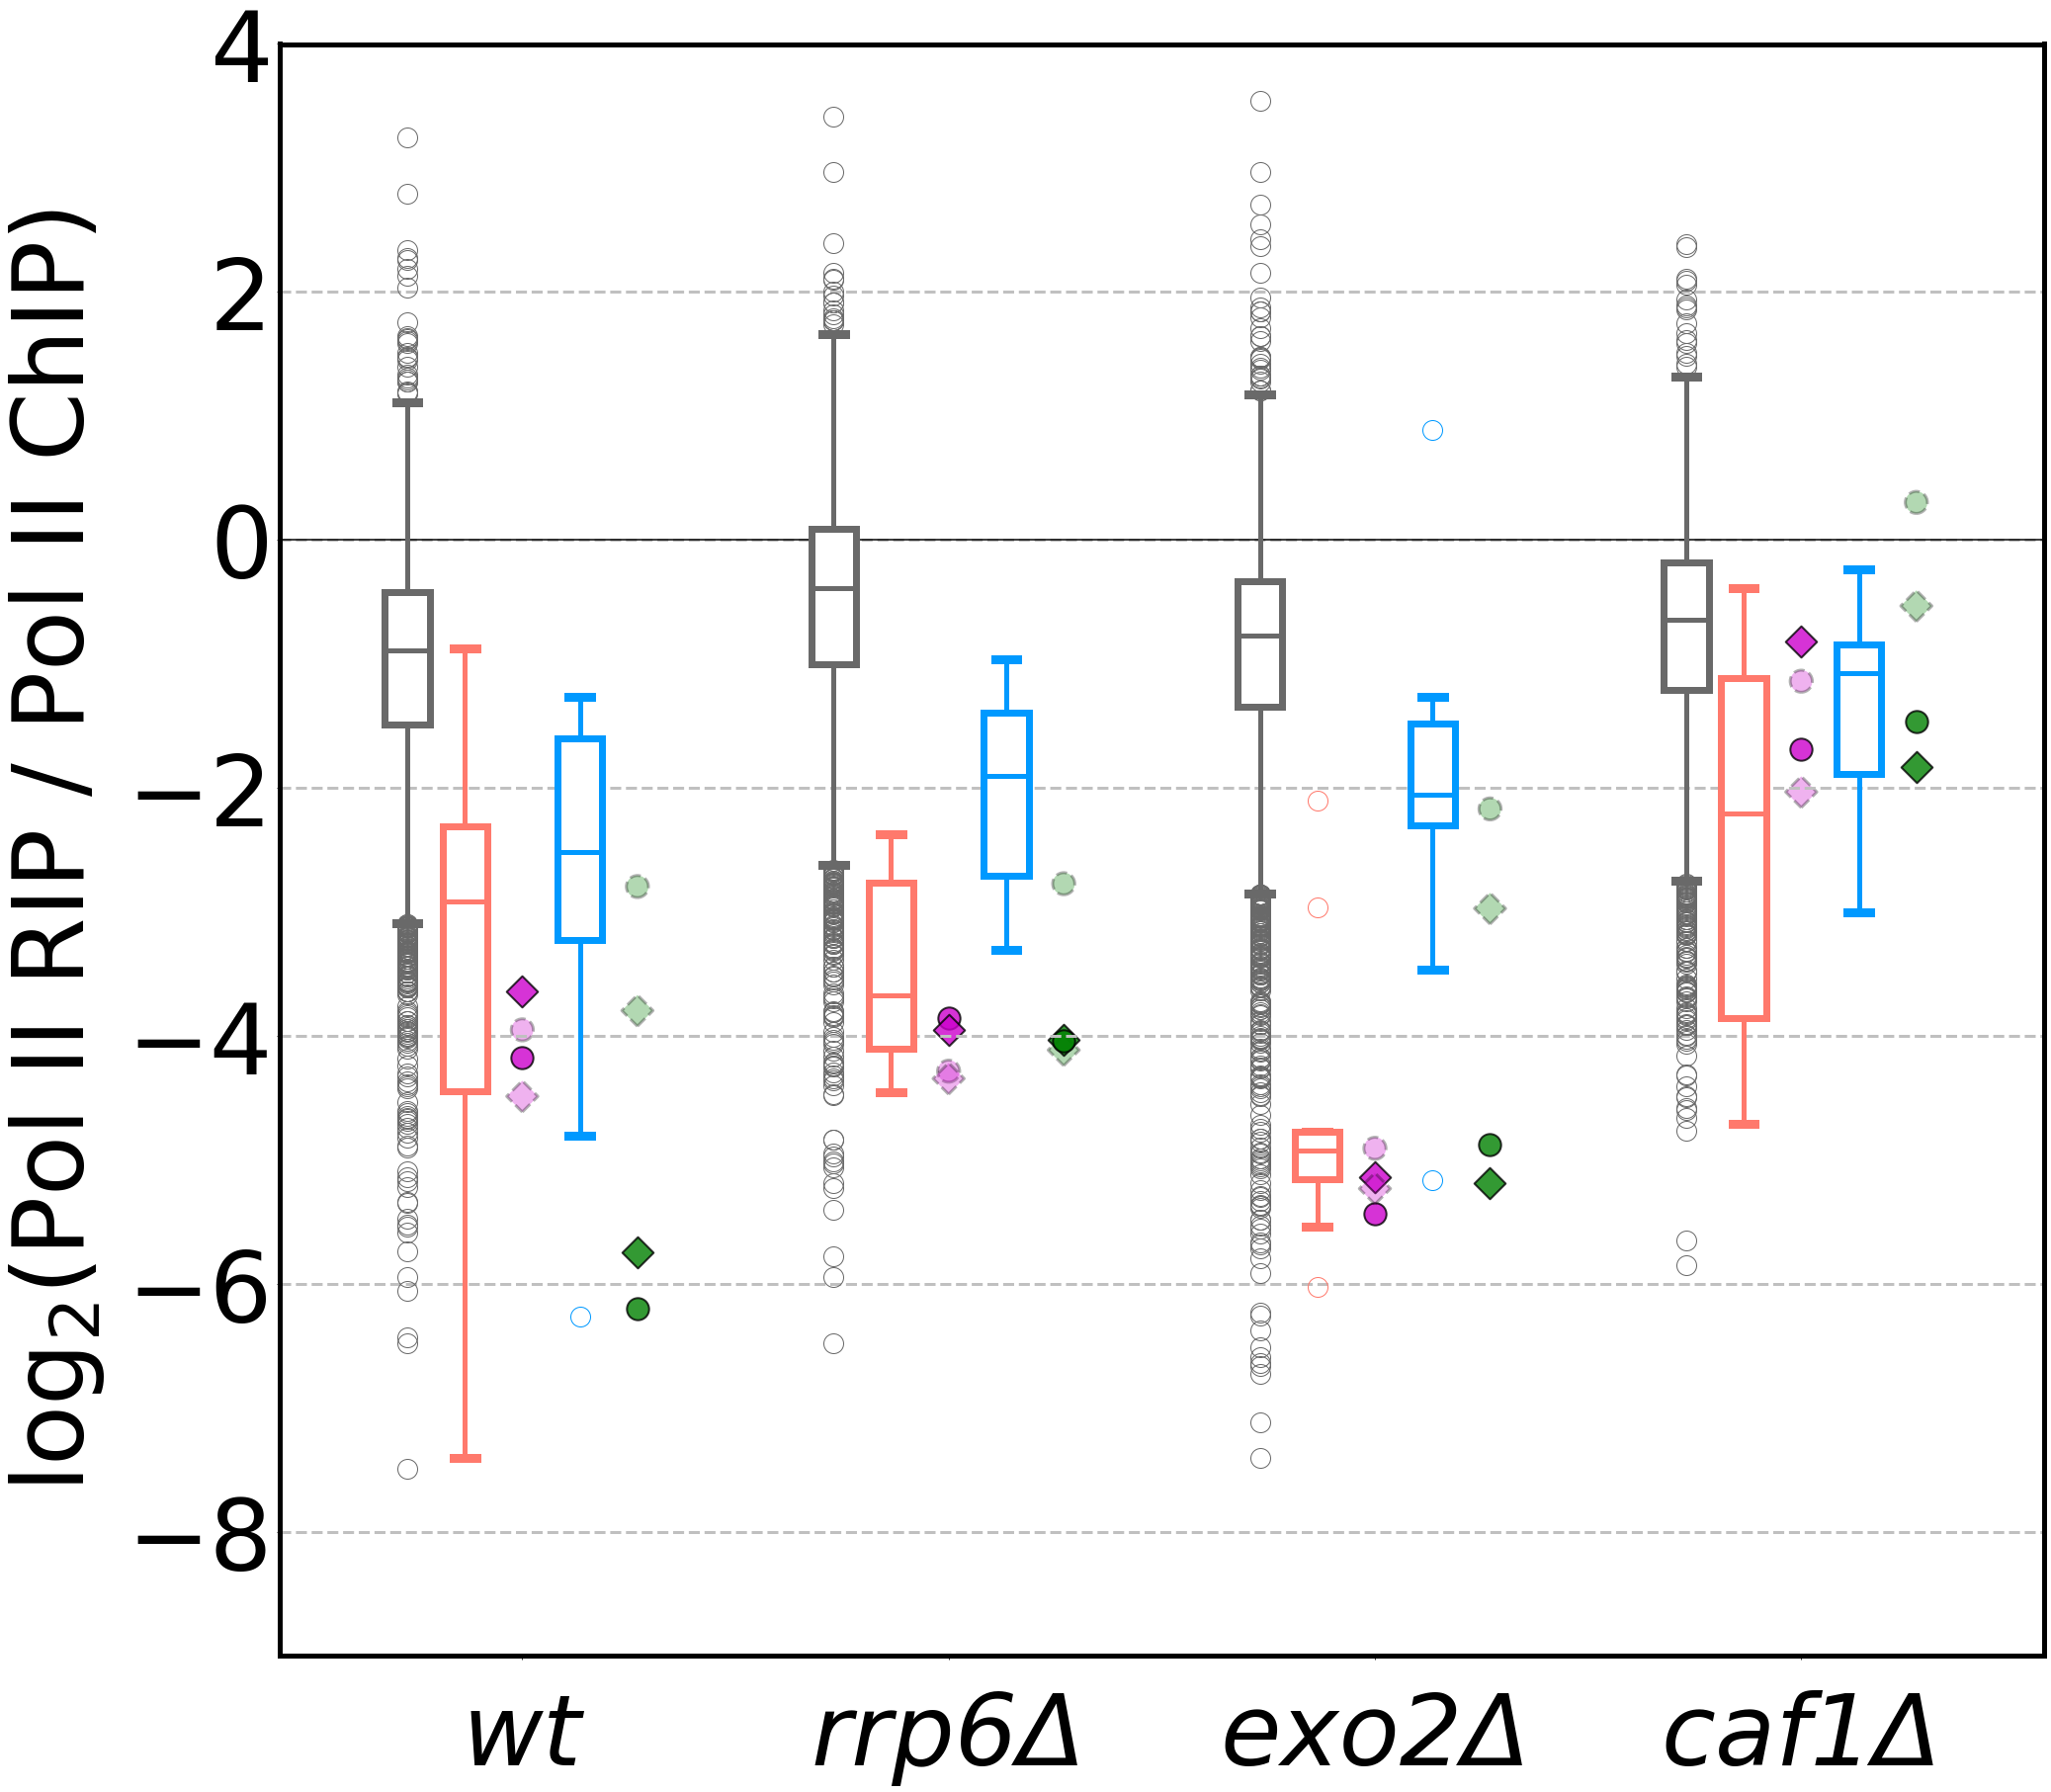

In [31]:
# data and label
samples = ['WT', '504', '530', '510']
x_labels = ['wt', 'rrp6Δ', 'exo2Δ', 'caf1Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure3-D_stranded.png')
out_path = os.path.join(fig_dir, 'Figure3-D_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels, 
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(32, 30),
                    dist=5, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$',
                    y_lim=(-9, 4),
                    hlines=[(0,'black')],
                    #widths=.8,
                    widths=.7,
                    xlable_size=100, ylable_size=100,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

-----

## Mutant group 3 - **Figure3-D_stranded-extra-ccr4-not-1**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(C+D)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) over indicated genes in wild type and mutant cells.

In [32]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-D_stranded-extra-ccr4-not-1.png


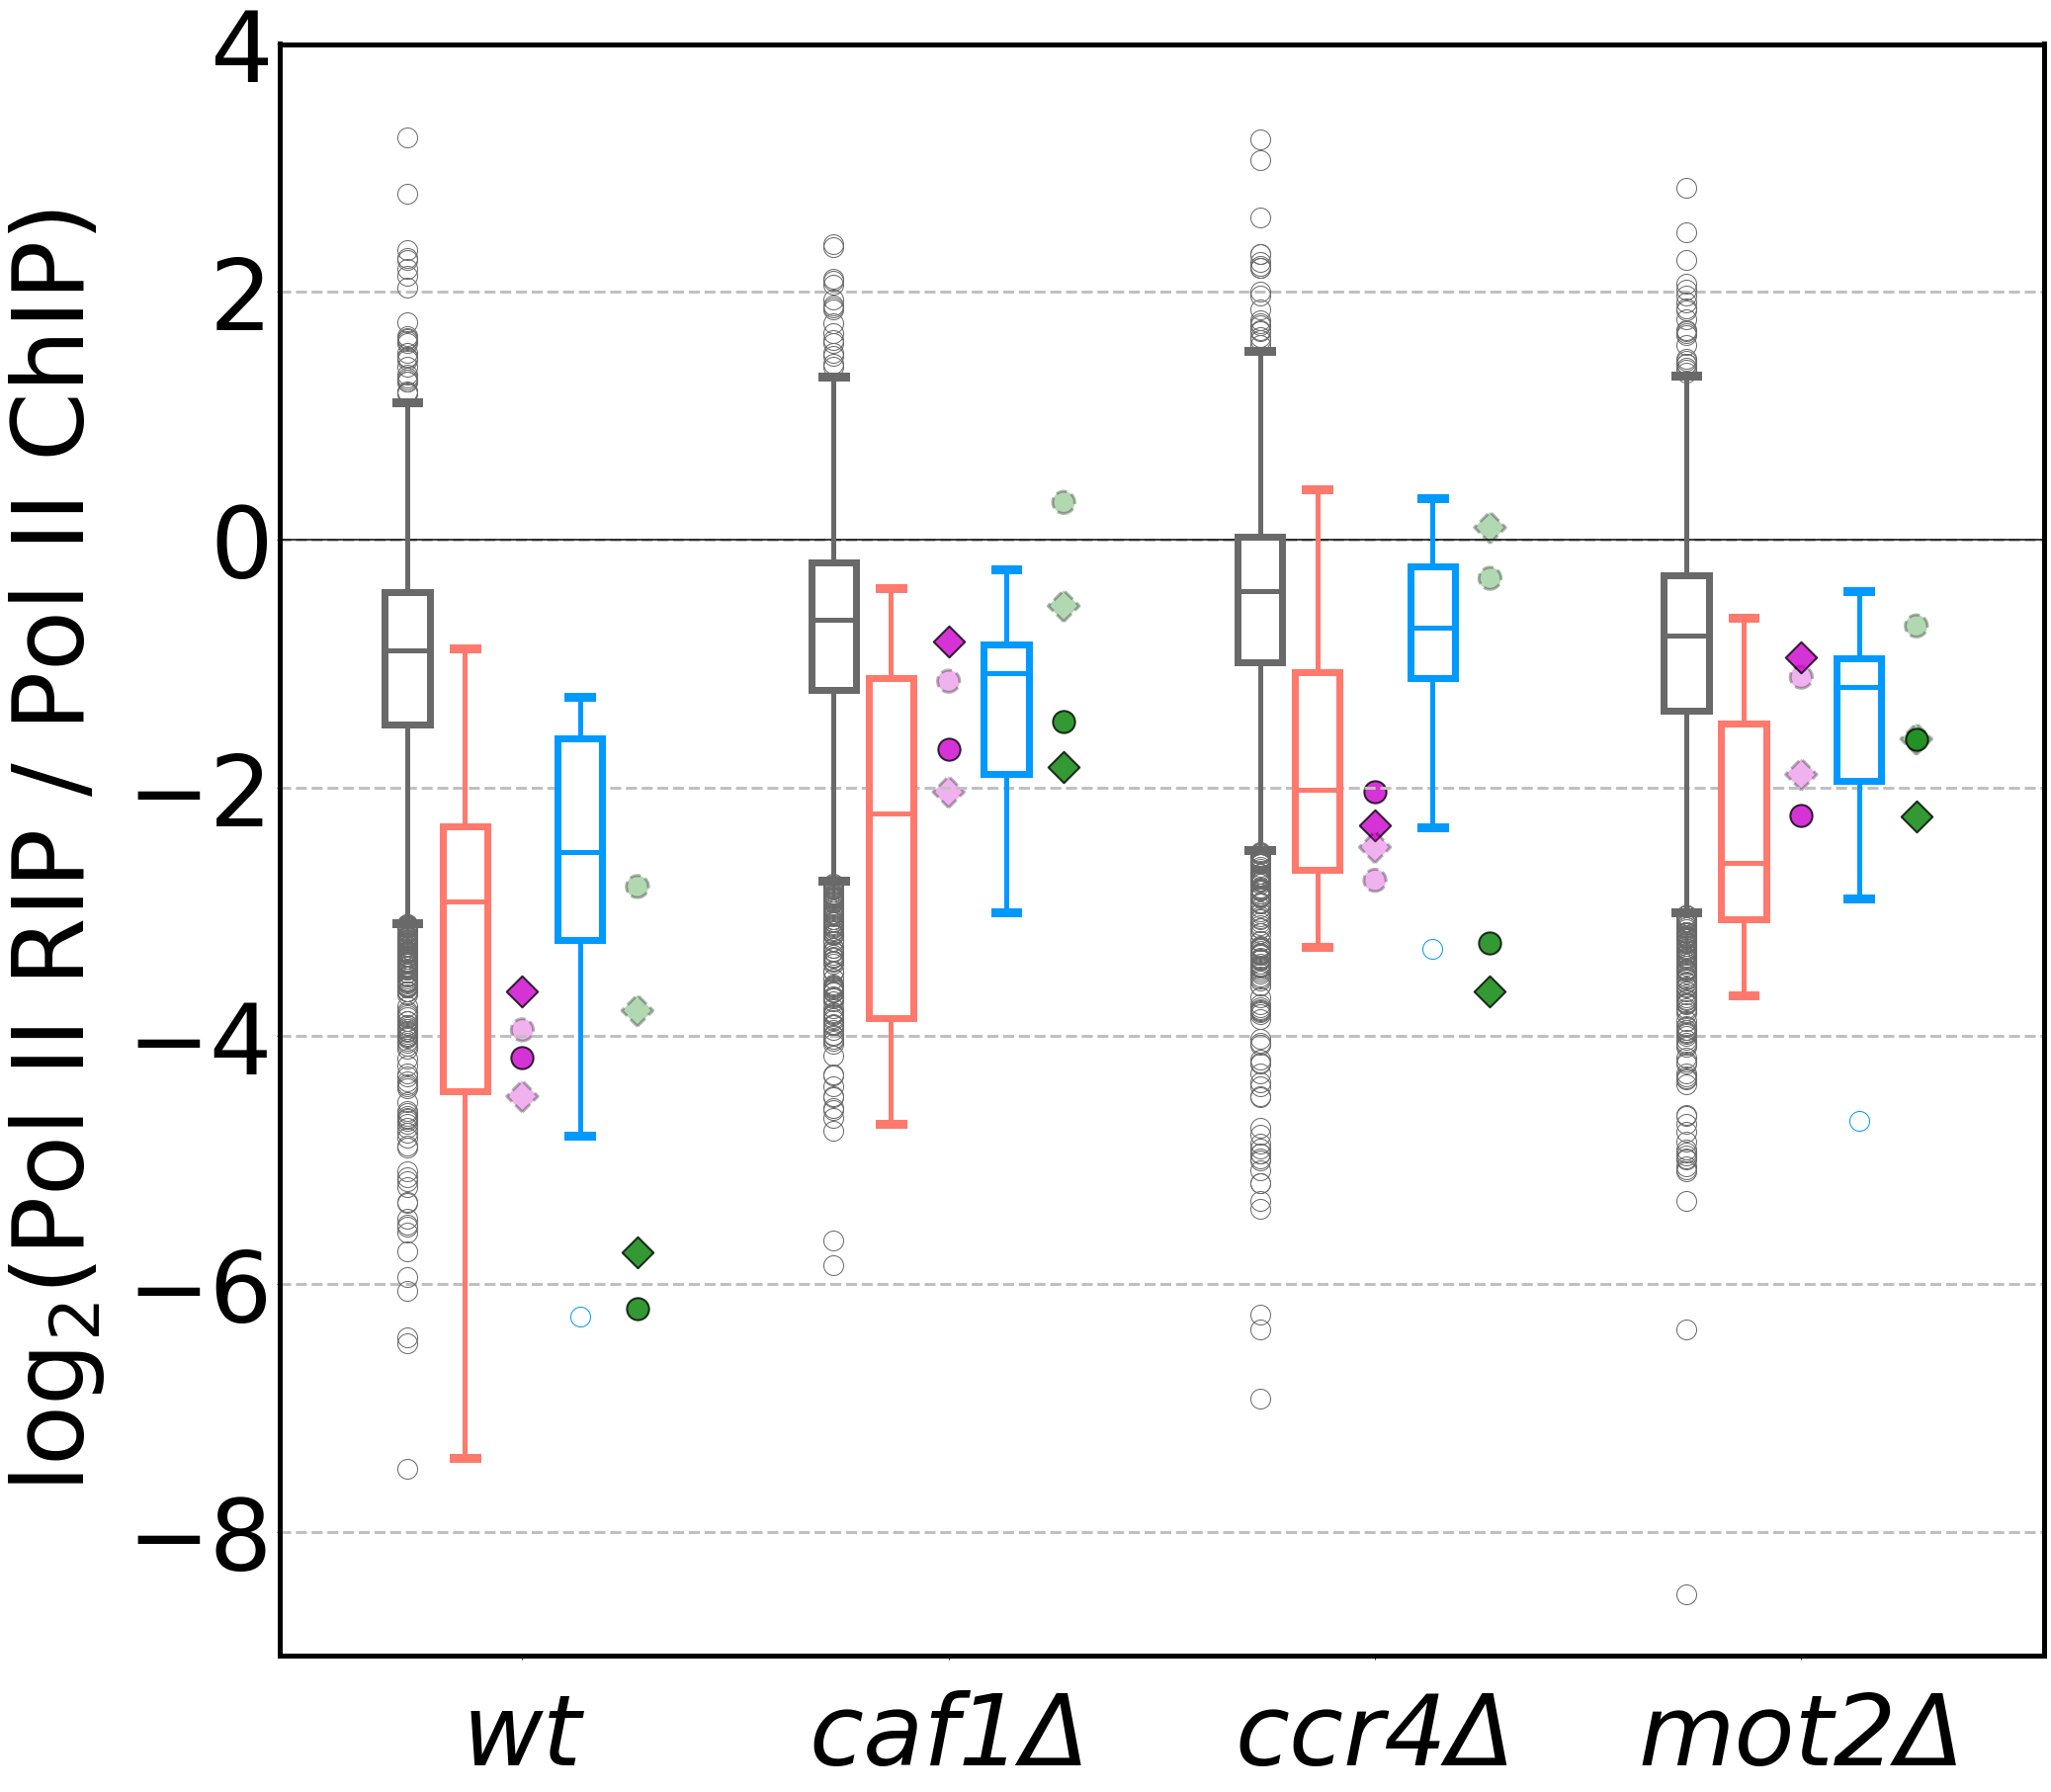

In [33]:
# data and labels
# samples = ['WT', '510', '544', '1022']
# x_labels = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

# # data and labels - new version v1
# samples = ['WT', '504', '530', '510', '544', '1022']
# x_labels = ['wt', 'rrp6Δ', 'exo2Δ', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

# data and labels - new version v1
samples = ['WT', '510', '544', '1022']
x_labels = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure3-D_stranded-extra-ccr4-not-1.png')
out_path = os.path.join(fig_dir, 'Figure3-D_stranded-extra-ccr4-not-1.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels, 
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(32, 30),
                    dist=5, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$',
                    y_lim=(-9, 4),
                    hlines=[(0,'black')],
                    #widths=.8,
                    widths=.7,
                    xlable_size=100, ylable_size=100,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

-----

## Mutant group 4 - **Figure3-D_stranded-extra-ccr4-not-2**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(C+D)** Box plot showing transcription efficiency (Pol II RIP / Pol II ChIP) over indicated genes in wild type and mutant cells.

In [34]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-D_stranded-extra-ccr4-not-2.png


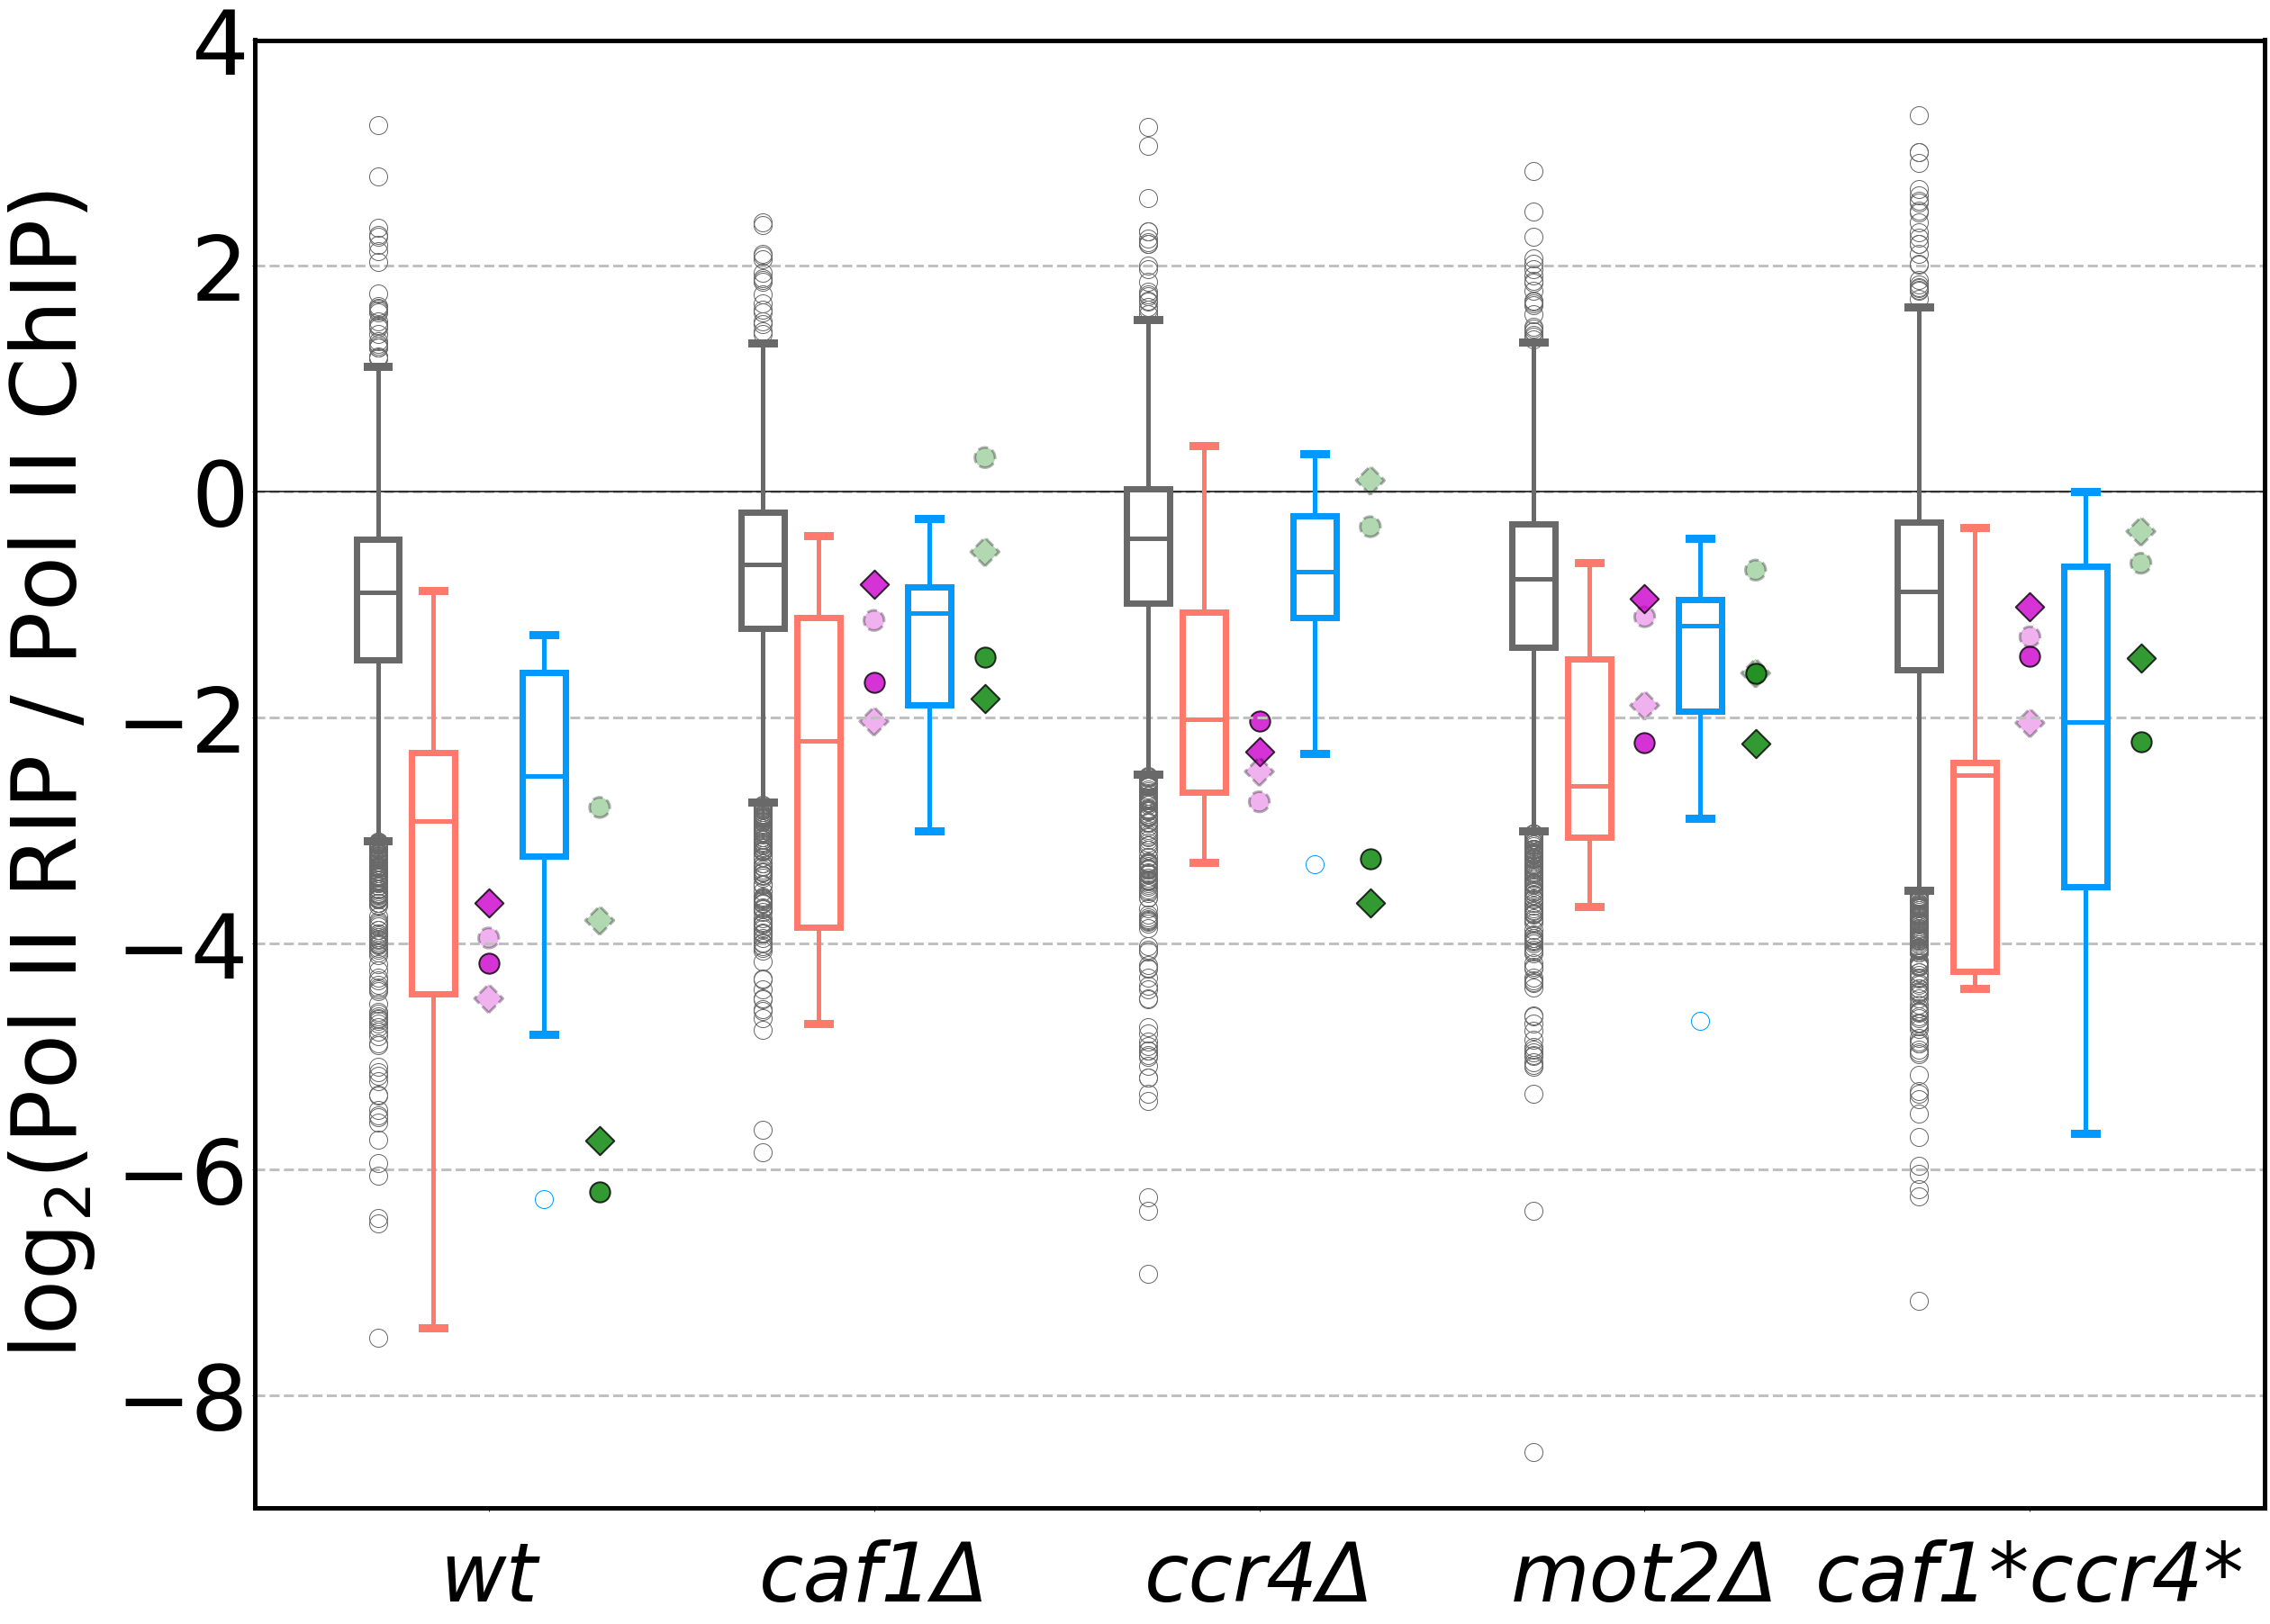

In [35]:
# data and label
samples = ['WT', '510', '544', '1022', '1168']
x_labels = ['wt','caf1Δ', 'ccr4Δ', 'mot2Δ', 'caf1*ccr4*']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure3-D_stranded-extra-ccr4-not-2.png')
out_path = os.path.join(fig_dir, 'Figure3-D_stranded-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels, 
                    out_path, 
                    figsize=(len(samples) * 8, 30),
                    #figsize=(44, 30),
                    dist=5, 
                    y_label='$\mathrm{log_2(Pol\ II\ RIP\ /\ Pol\ II\ ChIP)}$',
                    y_lim=(-9, 4),
                    hlines=[(0,'black')],
                    #widths=.8,
                    widths=.7, 
                    xlable_size=90, ylable_size=100,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

-----